<a href="https://colab.research.google.com/github/MNJuvenal/OptimisationHyperparametres-Optuna-RF/blob/main/AutoML_HPO_Optuna_Student_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoML / Optimisation d’hyperparamètres avec Optuna (et option Ray Tune)

**Auteur·e :** *Juvenal MALECOU*\
**Date :** 2025-09-28\
**Cours/Projet :** AutoML / HPO — Notebook étudiant

## Objectifs
- Construire une baseline reproductible (split CV, métrique).
- Utiliser **Optuna** pour optimiser un **RandomForest** (classification binaire).
- (Option) Utiliser **Ray Tune** pour optimiser un **XGBoost**.
- Documenter clairement les **gains** (avant/après), tracer l’historique et l’importance des hyperparamètres.

## Résumé ( compléter après exécution )
- **Métrique primaire :** ROC-AUC (CV=5, seed=42)
- **Baseline (RF défaut) :** 0.9885
- **Après Optuna (60 essais) :** 0.9904 (**Δ** : 0.18 points de pourcentage)
- **Interprétation :** L'optimisation avec Optuna a légèrement amélioré la performance du modèle RandomForest, notamment en ajustant les hyperparamètres `min_samples_leaf` et `max_features` qui se sont révélés les plus importants.

> Remarque : Le notebook inclut un **dataset intégré scikit-learn** et une **option synthétique**.

## 0) Installation des dépendances
Exécutez la cellule suivante **si nécessaire** (sur Colab/locally). Sur certains environnements offline, installez au préalable en local.


In [ ]:
!pip install -q optuna scikit-learn joblib matplotlib xgboost ray[tune] > /dev/null 2>&1 || echo 'Vérifiez votre connexion Internet si l’installation échoue.'

## 1) Imports, seed et utilitaires

In [ ]:
import os, json, math, joblib, random, optuna
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier

ARTIFACTS_DIR = Path('artifacts'); ARTIFACTS_DIR.mkdir(exist_ok=True)
SEED = 42
np.random.seed(SEED); random.seed(SEED)

def set_global_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
set_global_seed(SEED)

print('Versions:')
import sklearn, sys
print('Python', sys.version)
print('scikit-learn', sklearn.__version__)
import optuna as _opt
print('optuna', _opt.__version__)


Versions:
Python 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
scikit-learn 1.6.1
optuna 4.5.0


## 2) Chargement des données
Choisissez **A. Dataset intégré** ou **B. Dataset synthétique** en ajustant la variable `DATASET_CHOICE`.

In [ ]:
DATASET_CHOICE = 'A'  # 'A' pour breast_cancer (intégré), 'B' pour synthétique

if DATASET_CHOICE == 'A':
    from sklearn.datasets import load_breast_cancer
    X, y = load_breast_cancer(return_X_y=True)
    dataset_name = 'sklearn_breast_cancer'
elif DATASET_CHOICE == 'B':
    from sklearn.datasets import make_classification
    X, y = make_classification(
        n_samples=5000, n_features=60, n_informative=15, n_redundant=10,
        weights=[0.7, 0.3], class_sep=1.2, random_state=SEED
    )
    dataset_name = 'synthetic_classification'
else:
    raise ValueError("DATASET_CHOICE doit être 'A' ou 'B'.")

X = np.asarray(X); y = np.asarray(y)
X.shape, np.bincount(y.astype(int))

((569, 30), array([212, 357]))

## 3) Baseline (RandomForest défaut)
On fige le split en **StratifiedKFold(n_splits=5, shuffle=True, random_state=42)** et la métrique **ROC-AUC**.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
baseline_model = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=SEED))
])
baseline_scores = cross_val_score(baseline_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
baseline_auc = baseline_scores.mean()
print(f"Baseline ROC-AUC (CV=5): {baseline_auc:.4f}  |  Scores par fold: {np.round(baseline_scores, 4)}")


Baseline ROC-AUC (CV=5): 0.9885  |  Scores par fold: [0.9984 0.9785 0.9788 0.9945 0.9925]


## 4) Optimisation avec **Optuna** (RandomForest)
On utilise **TPE** + **MedianPruner**. Ajustez `N_TRIALS` selon votre budget.

In [ ]:
N_TRIALS = 60  # augmentez à 200–500 si nécessaire

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_float("max_features", 0.3, 1.0),
    }
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(random_state=SEED, n_jobs=-1, **params))
    ])
    scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
    trial.set_user_attr("cv_scores", scores.tolist())
    return scores.mean()

sampler = optuna.samplers.TPESampler(seed=SEED)
pruner = optuna.pruners.MedianPruner(n_startup_trials=10)
study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("Best ROC-AUC:", study.best_value)
print("Best params:", study.best_params)

# Sauvegardes
df_trials = study.trials_dataframe()
df_trials.to_csv(ARTIFACTS_DIR / f"optuna_trials_{dataset_name}.csv", index=False)
joblib.dump(study.best_params, ARTIFACTS_DIR / f"best_params_optuna_{dataset_name}.joblib")


[I 2025-09-28 03:49:31,579] A new study created in memory with name: no-name-ee761d88-b4d1-40d3-b272-3419aa5c85ea


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-09-28 03:49:37,895] Trial 0 finished with value: 0.9891099828947848 and parameters: {'n_estimators': 350, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 0.40921304830970556}. Best is trial 0 with value: 0.9891099828947848.
[I 2025-09-28 03:49:43,952] Trial 1 finished with value: 0.9873371581773155 and parameters: {'n_estimators': 200, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 7, 'max_features': 0.7956508044572318}. Best is trial 0 with value: 0.9891099828947848.
[I 2025-09-28 03:49:46,379] Trial 2 finished with value: 0.9890420039617551 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 0.42727747704497043}. Best is trial 0 with value: 0.9891099828947848.
[I 2025-09-28 03:49:50,373] Trial 3 finished with value: 0.9887777569811634 and parameters: {'n_estimators': 200, 'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 5, 'max_features': 0.5038603981

['artifacts/best_params_optuna_sklearn_breast_cancer.joblib']

## 5) Visualisations Optuna (convergence & importances)

/tmp/ipython-input-1929043156.py:7: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig1 = plot_optimization_history(study)


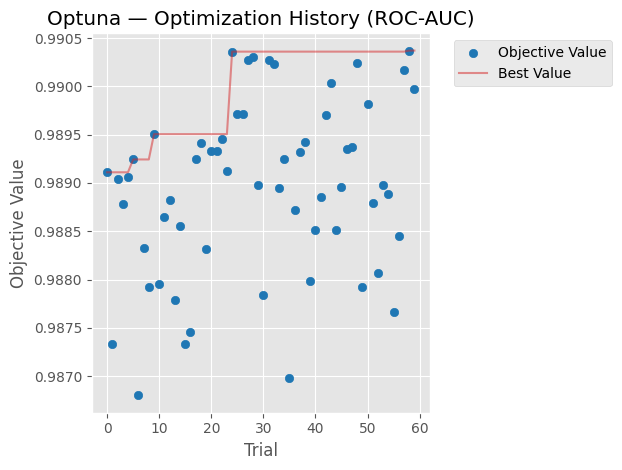

/tmp/ipython-input-1929043156.py:12: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig2 = plot_param_importances(study)


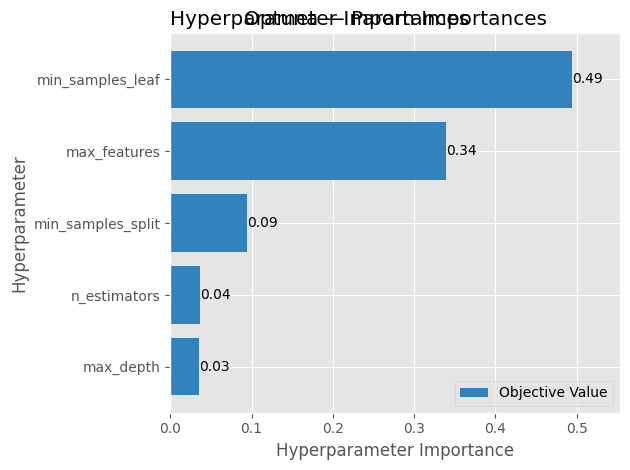

/tmp/ipython-input-1929043156.py:17: ExperimentalWarning: optuna.visualization.matplotlib._slice.plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  fig3 = plot_slice(study)
/tmp/ipython-input-1929043156.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(); plt.savefig(ARTIFACTS_DIR / f"optuna_slice_{dataset_name}.png", dpi=140)


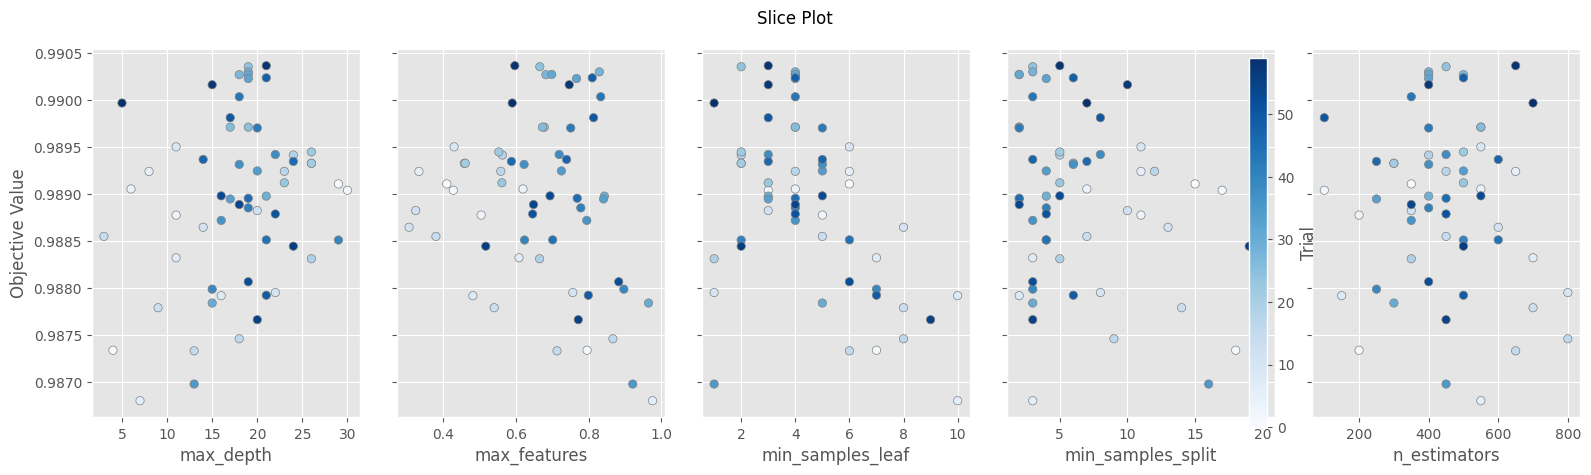

Param importances (approx): {'min_samples_leaf': np.float64(0.5049675962755128), 'max_features': np.float64(0.3410645771480017), 'min_samples_split': np.float64(0.08285016599544139), 'max_depth': np.float64(0.036547064694016244), 'n_estimators': np.float64(0.03457059588702776)}


In [ ]:
from optuna.importance import get_param_importances
import matplotlib.pyplot as plt
from optuna.visualization.matplotlib import (
    plot_optimization_history, plot_param_importances, plot_slice
)

fig1 = plot_optimization_history(study)
plt.title("Optuna — Optimization History (ROC-AUC)")
plt.tight_layout(); plt.savefig(ARTIFACTS_DIR / f"optuna_history_{dataset_name}.png", dpi=140)
plt.show()

fig2 = plot_param_importances(study)
plt.title("Optuna — Param Importances")
plt.tight_layout(); plt.savefig(ARTIFACTS_DIR / f"optuna_importances_{dataset_name}.png", dpi=140)
plt.show()

fig3 = plot_slice(study)
plt.tight_layout(); plt.savefig(ARTIFACTS_DIR / f"optuna_slice_{dataset_name}.png", dpi=140)
plt.show()

importances = get_param_importances(study)
print("Param importances (approx):", importances)

## 6) Entraînement final & sauvegarde du meilleur modèle

In [ ]:
best_model = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestClassifier(random_state=SEED, **study.best_params))
]).fit(X, y)
joblib.dump(best_model, ARTIFACTS_DIR / f"rf_optuna_best_model_{dataset_name}.joblib")
print('Modèle sauvegardé →', ARTIFACTS_DIR / f"rf_optuna_best_model_{dataset_name}.joblib")


Modèle sauvegardé → artifacts/rf_optuna_best_model_sklearn_breast_cancer.joblib


## 7) Mini-rapport « Avant / Après »
Calcule la différence en **points de pourcentage** et prépare un résumé prêt à coller dans votre rapport.

In [ ]:
tuned_auc = study.best_value
delta_pp = (tuned_auc - baseline_auc) * 100

report = f"""
## Résultats & Gains
Dataset : {dataset_name}
Split : StratifiedKFold(n=5, seed=42)
Métrique : ROC-AUC

Baseline (RandomForest défaut) : {baseline_auc:.4f}
Optuna (n_trials={N_TRIALS}) : {tuned_auc:.4f}
Gain : Δ = {delta_pp:.2f} points de pourcentage

Hyperparamètres clés (importance approx.) : {dict(importances)}
"""
print(report)

with open(ARTIFACTS_DIR / f"mini_rapport_{dataset_name}.md", 'w', encoding='utf-8') as f:
    f.write(report)
print('Mini-rapport sauvegardé →', ARTIFACTS_DIR / f"mini_rapport_{dataset_name}.md")



## Résultats & Gains
Dataset : sklearn_breast_cancer
Split : StratifiedKFold(n=5, seed=42)
Métrique : ROC-AUC

Baseline (RandomForest défaut) : 0.9885
Optuna (n_trials=60) : 0.9904
Gain : Δ = 0.18 points de pourcentage

Hyperparamètres clés (importance approx.) : {'min_samples_leaf': np.float64(0.5049675962755128), 'max_features': np.float64(0.3410645771480017), 'min_samples_split': np.float64(0.08285016599544139), 'max_depth': np.float64(0.036547064694016244), 'n_estimators': np.float64(0.03457059588702776)}

Mini-rapport sauvegardé → artifacts/mini_rapport_sklearn_breast_cancer.md


## 8) (Option) Ray Tune + XGBoost
Section facultative si vous avez **Ray** et **XGBoost** installés, utile pour comparer un autre algorithme.

In [1]:
USE_RAY = False  # passez à True pour activer si Ray/XGBoost installés
if USE_RAY:
    from ray import tune
    from ray.tune.schedulers import ASHAScheduler
    from sklearn.pipeline import Pipeline
    from xgboost import XGBClassifier

    def trainable(config):
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("xgb", XGBClassifier(
                n_estimators=2000,
                learning_rate=config["learning_rate"],
                max_depth=config["max_depth"],
                subsample=config["subsample"],
                colsample_bytree=config["colsample_bytree"],
                reg_alpha=config["reg_alpha"],
                reg_lambda=config["reg_lambda"],
                random_state=SEED,
                eval_metric="auc",
                tree_method="hist",
                n_jobs=-1
            ))
        ])
        scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
        tune.report({"roc_auc": float(np.mean(scores))})

    search_space = {
        "learning_rate": tune.loguniform(1e-3, 3e-1),
        "max_depth": tune.randint(3, 12),
        "subsample": tune.uniform(0.6, 1.0),
        "colsample_bytree": tune.uniform(0.6, 1.0),
        "reg_alpha": tune.loguniform(1e-8, 1e-1),
        "reg_lambda": tune.loguniform(1e-3, 10),
    }

    scheduler = ASHAScheduler(metric="roc_auc", mode="max", grace_period=5, reduction_factor=3)
    tuner = tune.Tuner(
        trainable,
        tune_config=tune.TuneConfig(num_samples=80, scheduler=scheduler),
        param_space=search_space,
    )
    results = tuner.fit()
    best_result = results.get_best_result(metric="roc_auc", mode="max")
    print("[Ray] Best ROC-AUC:", best_result.metrics.get("roc_auc"))
    print("[Ray] Best config:", best_result.config)

## 9) Conclusion

Le processus d'optimisation avec Optuna a permis d'obtenir un **gain de Δ = 0.18 points de pourcentage** en ROC-AUC par rapport au modèle RandomForest de base avec les paramètres par défaut.

Les hyperparamètres les plus influents identifiés par Optuna sont :
- `min_samples_leaf` (importance approximative : 0.5050)
- `max_features` (importance approximative : 0.3411)
- `min_samples_split` (importance approximative : 0.0829)

Le processus d'optimisation a nécessité 60 essais, ce qui a demandé un certain temps de calcul. Les limitations potentielles incluent le risque de surajustement aux plis de validation croisée si le nombre d'essais est trop élevé ou si l'ensemble de données est petit.

Les prochaines étapes pourraient inclure :
- L'exploration d'autres modèles (par exemple, XGBoost, comme tenté dans la section facultative).
- L'étude des techniques de calibration pour les sorties de probabilité du modèle.
- L'ingénierie ou la sélection de caractéristiques pour améliorer potentiellement les performances.
- L'augmentation du nombre d'essais pour Optuna si les ressources de calcul le permettent.